Copyright (c) 2026 Graphcore Ltd. All rights reserved.

# Paper figures

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import Tensor
from typing import Any
import math

import qkernels
import plot_utils

plot_utils.configure()

Recommend (Ubuntu):
  sudo apt-get install cm-super dvipng fonts-cmu texlive-latex-extra


## Theoretical

In [6]:
l40s_bw = 864e9
l40s_bf16_flops = 362e12
print(f"L40S hardware intensity {l40s_bf16_flops/ l40s_bw:.0f} flops/byte")
print("m=400, k=n=large operational intensity", 1/(1/400) * (2/2))
print(f"m=400, k=n=8192 compute_time {2*400*8192*8192/l40s_bf16_flops*1000:.2f} ms, transfer_time {(400*8192 + 8192*8192 + 400*8192)*2/l40s_bw*1000:.2f} ms")

L40S hardware intensity 419 flops/byte
m=400, k=n=large operational intensity 400.0
m=400, k=n=8192 compute_time 0.15 ms, transfer_time 0.17 ms


In [7]:
def l40s_critical_m(P_w: float) -> float:
    return (P_w / 16) * (l40s_bf16_flops / l40s_bw)
for P_w in [16, 4.25, 1.25]:
    print(f"P_w = {P_w}, m_critical = {math.floor(l40s_critical_m(P_w)):.0f}, peak speedup = {16/P_w:.1f}")

P_w = 16, m_critical = 418, peak speedup = 1.0
P_w = 4.25, m_critical = 111, peak speedup = 3.8
P_w = 1.25, m_critical = 32, peak speedup = 12.8


remote: Updating references: 100% (1/1)           


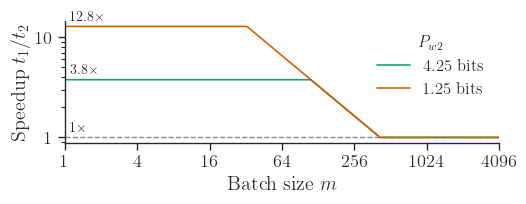

In [23]:
def l40_speedup_ratio(P_w1: float, P_w2: float, m: Tensor) -> Tensor:
    one = torch.tensor(1.0)
    return (torch.maximum(one, (P_w1 / (16*m)) * (l40s_bf16_flops / l40s_bw))
            / torch.maximum(one, (P_w2 / (16*m)) * (l40s_bf16_flops / l40s_bw)))

_, ax = plt.subplots(figsize=(5.5, 2.25))
m = torch.arange(1, 4099)
ax.plot(m, l40_speedup_ratio(16, 4.25, m), label=r"$4.25$ bits")
ax.plot(m, l40_speedup_ratio(16, 1.25, m), label=r"$1.25$ bits")
ax.set_yticks(torch.arange(2, 14, 2))
ax.axhline(y=1, color="#888888", ls="--", lw=1, zorder=-1)
for speedup in [1, 3.8, 12.8]:
    ax.annotate(f"${speedup}\\times$", xy=(1, speedup), xytext=(4, 5), textcoords="offset points", fontsize=10)
ax.legend(title="$P_{w2}$", fontsize=12, title_fontsize=12)
ax.set_xlabel("Batch size $m$")
ax.set_ylabel(r"Speedup $t_1 / t_2$")
ax.set_xscale("log", base=2)
ax.set_yscale("log")
ax.set_xticks(2**torch.arange(0, 13, 2))
ax.set_xlim((1, m.max()))
ax.xaxis.set_major_formatter("{x:.0f}")
ax.yaxis.set_major_formatter("{x:.0f}")

plot_utils.tidy(ax.figure)
plot_utils.save("perf_theoretical")

## `code/dequant_matmul.py`, `code/dequant_matmul_defer_scale.py`

In [26]:
def dequant_matmul() -> Any:
    def dequant_matmul(x, Wq, Wscale, lut8):
        """
        x      :: batch_size x input_size x bf16
        Wq     :: output_size x (input_size//elements_per_byte) x uint8
        Wscale :: output_size x (input_size//block_size) x bf16
        lut8   :: 256 x elements_per_byte x bf16
        return :: batch_size x output_size x bf16
        """
        Wu = lut8[Wq.long()].flatten(start_dim=1)
        B = Wu.shape[1] // Wscale.shape[1]
        W = Wu.view(*Wscale.shape, B).mul(Wscale.unsqueeze(2)).flatten(start_dim=1)
        return x @ W.T
    return dequant_matmul  # IGNORE

def dequant_matmul_defer_scale() -> Any:
    def dequant_matmul_defer_scale(x, Wq, Wscale, lut8):
        Wu = lut8[Wq.long()].flatten(start_dim=1)
        B = Wu.shape[1] // Wscale.shape[1]
        z = torch.einsum("mGg,hGg->mhG", x.unflatten(1, (-1, B)), Wu.unflatten(1, (-1, B)))
        return torch.einsum("mhG,hG->mh", z, Wscale)
    return dequant_matmul_defer_scale  # IGNORE

def test_dequant_matmul():
    torch.manual_seed(0)
    x = torch.randn(5, 32, device="cuda")
    Wq = torch.randint(0, 256, (70, 32//2), device="cuda", dtype=torch.uint8)
    Wscale = torch.randn((70, 8), device="cuda")
    lut8 = torch.randn((256, 2), device="cuda")
    ref = torch.compiler.disable(qkernels.mm_lut_ref)(x, Wq, lut8, Wscale)
    out = dequant_matmul()(x, Wq, Wscale, lut8)
    torch.testing.assert_close(ref, out)
    out_defer = dequant_matmul_defer_scale()(x, Wq, Wscale, lut8)
    torch.testing.assert_close(ref, out_defer)
    # torch.testing.assert_close(out, out_defer, atol=0, rtol=0)  # not an exact match (expected!)

test_dequant_matmul()

plot_utils.save_code(dequant_matmul)
plot_utils.save_code(dequant_matmul_defer_scale)

On branch master
Your branch is up to date with 'origin/master'.

nothing to commit, working tree clean
Error running "git -C /home/ubuntu/FusedDequantisationKernels/notebooks/paper commit -m 'Update figures' --quiet" -- aborting


remote: Updating references: 100% (1/1)           


# Micro-benchmarks

In [40]:
df = pd.read_json("../out/l40s-py-2026-01-17T22-56-28.jsonl", lines=True)

print("device", *df.device.unique())
print("torch_version", *df.torch_version.unique())
print("cuda_version", *df.cuda_version.unique())
print("triton_version", *df.triton_version.unique())
print("reps", *df.outer_reps.unique(), "x", *df.inner_reps.unique())
print()

df = df.drop(columns=[
    "n", "g", "copies", "inner_reps", "outer_reps",
    "id", "device", "cuda_version", "torch_version", "triton_version", "commit",
])
df = df.rename(columns=dict(bits="element_bits"))

df["gb_s"] = df["bytes_rw"] / df["avg_time"] / 1e9
df["tflops"] = df["ops"] / df["avg_time"] / 1e12
df["tflops_stderr"] = df["ops"] * df["avg_time_stderr"] / df["avg_time"]**2 / 1e12
df["avg_bits"] = df["element_bits"].apply(lambda b: b + 0.25*(b < 16))

# Remove "mm" tests where "mv" was also run, for batch size 1
df = df[~((df.m == 1) & df.test.isin(["mm", "mm_ref", "mm_lut8_ref_unscaled", "mm_lut8_ref", "mm_lut8"]))]

# Rename test -> impl
df = df.pipe(
    lambda d: d.assign(impl=d.test.apply(dict(
        mm="Triton", mv="Triton",
        mm_ref="Torch", mv_ref="Torch",
        mm_lut8_ref_unscaled="torch.compile:unscaled", mv_lut8_ref_unscaled="torch.compile:unscaled",
        mv_lut8_ref="torch.compile", mm_lut8_ref="torch.compile",
        mv_lut8="Triton", mm_lut8="Triton",
        marlin="Marlin",
    ).__getitem__))
).drop(columns=["test"])
assert df.groupby(["m", "k", "element_bits", "impl"]).avg_time.count().max() == 1, "duplicate entries with same impl name"


for k in  ["m", "k", "element_bits", "impl"]:
    print(k, df[k].unique())

df.head()

device NVIDIA L40S
torch_version 2.9.1+cu128
cuda_version 12.8
triton_version 3.5.1
reps 100 x 100

m [  1   4  16  64 256]
k [8192 6144 4096 3072]
element_bits [16  8  4  2  1]
impl ['Torch' 'Triton' 'torch.compile:unscaled' 'torch.compile' 'Marlin']


,m,k,element_bits,bytes_rw,ops,avg_time,avg_time_stderr,gb_s,tflops,tflops_stderr,avg_bits,impl
0,1,8192,16,134250496,134217728,0.000182,2.073154e-08,739.281668,0.739101,0.000084,16.00,Torch
1,1,8192,16,134250496,134217728,0.000176,1.946425e-08,764.350473,0.764164,0.000085,16.00,Triton
4,1,8192,8,69238784,134217728,0.000090,2.303511e-09,769.148813,1.490977,0.000038,8.25,torch.compile:unscaled
5,1,8192,8,69238784,134217728,0.000283,3.898155e-07,244.655836,0.474259,0.000653,8.25,torch.compile
6,1,8192,8,69238784,134217728,0.000096,1.730201e-08,723.931694,1.403324,0.000254,8.25,Triton


## `perf_micro_m_k_bits_impl`

Relative 2*stderr mean 0.002302992657486617
Relative 2*stderr max 0.01174619574004101


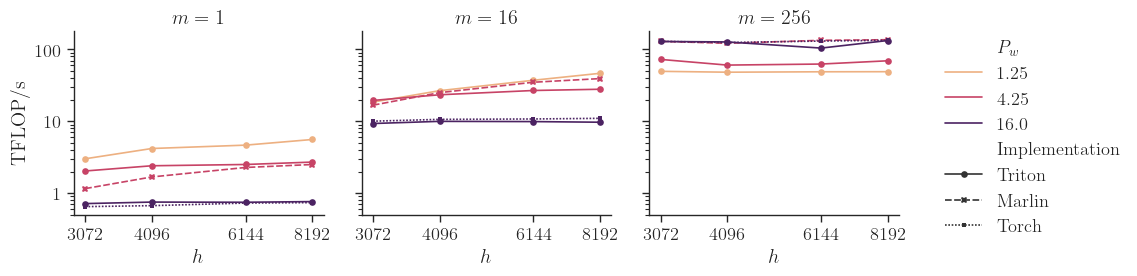

In [ ]:
d = (df
    .pipe(lambda d: d[~d.impl.isin(["torch.compile", "torch.compile:unscaled"])])
    .pipe(lambda d: d[d.element_bits.isin([1, 4, 16])])
    .pipe(lambda d: d[d.m.isin([1, 16, 256])])
)

print("Relative 2*stderr mean", 2 * (d.tflops_stderr / d.tflops).mean())
print("Relative 2*stderr max", 2 * (d.tflops_stderr / d.tflops).max())

g = sns.relplot(
    data=d,
    y="tflops", x="k", col="m",
    style="impl", style_order=["Triton", "Marlin", "Torch"],
    hue="avg_bits", hue_norm=matplotlib.colors.LogNorm(), palette=plot_utils.SEQ_PALETTE,
    kind="line", markers=True, height=3, aspect=0.9, mew=0,
)
for ax in g.axes.flatten():
    ax.set_xscale("log", base=2)
    ax.xaxis.set_major_formatter("{x:.0f}")
    ax.set_xticks([3072, 4096, 6144, 8192])
    ax.set_yscale("log")
    ax.yaxis.set_major_formatter("{x:.0f}")

for m, ax in g.axes_dict.items():
    ax.set_title(f"$m={m}$")
g.figure.legend(
    handles=g.legend.legend_handles,
    labels=[text.get_text() for text in g.legend.get_texts()],
    loc="center left",
    bbox_to_anchor=(1, 0.5),
)
g.legend.remove()

plot_utils.tidy(g.figure)
plot_utils.save("perf_micro_m_k_bits_impl")

## `tables/perf_micro_m1_impl`

In [44]:
d = (df
    .pipe(lambda d: d[~d.impl.isin(["torch.compile:unscaled"])])
    .pipe(lambda d: d[d.element_bits.isin([1, 4, 16])])
    .pipe(lambda d: d[d.m == 1])
    .pipe(lambda d: d[d.k == 8192])
    .pipe(lambda d: d.assign(speedup_ratio=lambda d: d[d.impl=="Torch"].iloc[0].avg_time / d.avg_time))
    .pipe(lambda d: d.assign(theoretical_speedup_ratio=lambda d: d[d.impl=="Torch"].iloc[0].bytes_rw / d.bytes_rw))
    .pipe(lambda d: d.assign(avg_time_str=d.apply(lambda s: f"${s.avg_time*1e6:.1f}\\,\\mathrm{{\\upmu s}}$ (${s.speedup_ratio:.1f}\\times$)", axis=1)))
    .pipe(lambda d: d.assign(gb_s_str=d.gb_s.apply(lambda x: f"${x:.0f}\\,\\mathrm{{GB/s}}$")))
    .pipe(lambda d: d.assign(avg_time_stderr_str=d.avg_time_stderr.apply(lambda s: f"${s*1e6:.2f}\\,\\mathrm{{\\upmu s}}$")))
    .sort_values(["avg_bits", "avg_time"], ascending=False)
)

display(d[["avg_bits", "impl", "avg_time", "avg_time_stderr", "speedup_ratio", "theoretical_speedup_ratio", "gb_s"]]
    .style.format(dict(avg_time=lambda x: f"{x*1e6:.1f} us", gb_s="{:.0f} GB/s", avg_time_stderr="{:.1e}")).hide())

cols = dict(avg_bits="", impl="", avg_time_str="Time (Speedup)", gb_s_str="Effective Bandwidth")
align = "llrr"
print(plot_utils.fmt_latex_booktabs(d, cols=cols, align=align))
plot_utils.save_table("perf_micro_m1_impl", d, cols=cols, align=align)

avg_bits,impl,avg_time,avg_time_stderr,speedup_ratio,theoretical_speedup_ratio,gb_s
16.000000,Torch,181.6 us,2.1e-08,1.000000,1.000000,739 GB/s
16.000000,Triton,175.6 us,1.9e-08,1.033910,1.000000,764 GB/s
4.250000,torch.compile,772.3 us,5.7e-07,0.235145,3.762167,46 GB/s
4.250000,Marlin,53.5 us,3.2e-08,3.391979,3.762167,667 GB/s
4.250000,Triton,49.5 us,8.0e-09,3.666746,3.762167,721 GB/s
1.250000,torch.compile,770.4 us,3.3e-07,0.235719,12.763240,14 GB/s
1.250000,Triton,24.0 us,1.4e-07,7.563547,12.763240,438 GB/s


\begin{tabular}{llrr} \toprule
  $P_w$ & Implementation & Time (Speedup) & Effective Bandwidth \\\midrule
  $16$ & Torch & $181.6\,\mathrm{\upmu s}$ ($1.0\times$) & $739\,\mathrm{GB/s}$ \\
  $16$ & Triton & $175.6\,\mathrm{\upmu s}$ ($1.0\times$) & $764\,\mathrm{GB/s}$ \\
  $4.25$ & torch.compile & $772.3\,\mathrm{\upmu s}$ ($0.2\times$) & $46\,\mathrm{GB/s}$ \\
  $4.25$ & Marlin & $53.5\,\mathrm{\upmu s}$ ($3.4\times$) & $667\,\mathrm{GB/s}$ \\
  $4.25$ & Triton & $49.5\,\mathrm{\upmu s}$ ($3.7\times$) & $721\,\mathrm{GB/s}$ \\
  $1.25$ & torch.compile & $770.4\,\mathrm{\upmu s}$ ($0.2\times$) & $14\,\mathrm{GB/s}$ \\
  $1.25$ & Triton & $24.0\,\mathrm{\upmu s}$ ($7.6\times$) & $438\,\mathrm{GB/s}$ \\
\bottomrule
\end{tabular}


remote: Updating references: 100% (1/1)           


# Model benchmarks

In [6]:
# df = pd.read_json("../out/l40s-models-2026-01-20T14-17-30.jsonl", lines=True)
df = pd.read_json("../out/l40s-models-2026-01-28T22-37-52.jsonl", lines=True)

print("torch_version", *df.torch_version.unique())
print("cuda_version", *df.cuda_version.unique())
print("triton_version", *df.triton_version.unique())
print("device", *df.device.unique())
print("reps", *df.reps.unique())
print("block_size", *df.block_size.unique())
print()
# assert len(df.commit.unique()) == 1
assert all(df.model.apply(lambda s: s.startswith("custom-llama-")))

df = df.drop(columns=[
    "reps", "id", "device", "cuda_version", "torch_version", "triton_version", "block_size",
    "output", "commit",
])
df["model"] = df["model"].apply(lambda s: s.replace("custom-llama-", ""))
df = df.rename(columns=dict(bits="element_bits"))
print("Dropping", sum(~df.error.isna()), "runs with errors")
df = df[df.error.isna()].drop(columns=["error"])
df["impl"] = df["kernel"].fillna("torch").apply(lambda k: {
    "marlin": "Marlin (Linear)", "marlin-lut": "Marlin",
    "torch": "Torch", "triton": "Triton", "torch.compile": "torch.compile",
}[k])
df = df.drop(columns=["kernel"])
df["element_bits"] = df["element_bits"].fillna(16).astype(int)
df["avg_bits"] = df["element_bits"].apply(lambda b: b + 0.25*(b < 16))

df["tokens_s"] = df["batch_size"] / df["avg_time"]
df["tokens_s_stderr"] = df["batch_size"] * df["avg_time_stderr"] / df["avg_time"]**2
df["gb_s"] = df["bytes_rw"] / df["avg_time"] / 1e9
df["tflops"] = df["ops"] / df["avg_time"] / 1e12

assert df.groupby(["model", "batch_size", "element_bits", "impl"]).count().avg_time.max() == 1

display(df.head())

torch_version 2.9.1+cu128
cuda_version 12.8
triton_version 3.5.1
device NVIDIA L40S
reps 100
block_size nan 64.0

Dropping 5 runs with errors


,model,batch_size,parameters,bytes_rw,ops,avg_time,avg_time_stderr,element_bits,skip,impl,avg_bits,tokens_s,tokens_s_stderr,gb_s,tflops
0,4B,1,3.883552e+09,6.979099e+09,7.767103e+09,0.011257,2.453627e-07,16,NaN,Torch,16.00,88.837412,0.001936,620.005062,0.690009
1,4B,1,3.883552e+09,2.432735e+09,7.767103e+09,0.005260,2.127769e-07,4,^lm_head$,Triton,4.25,190.100723,0.007689,462.464725,1.476532
2,4B,1,3.883552e+09,2.432735e+09,7.767103e+09,0.006600,3.088614e-07,4,^lm_head$,Marlin,4.25,151.521331,0.007091,368.611281,1.176882
3,4B,1,3.883552e+09,2.432735e+09,7.767103e+09,0.006404,2.966344e-07,4,^lm_head$,Marlin (Linear),4.25,156.151749,0.007233,379.875862,1.212847
4,4B,1,3.883552e+09,2.432735e+09,7.767103e+09,0.006666,2.674960e-07,4,^lm_head$,torch.compile,4.25,150.004711,0.006019,364.921746,1.165102


## `perf_model_params_m_bits_impl`

Relative 2*stderr mean 0.0003937507972367792
Relative 2*stderr max 0.00169051247200207


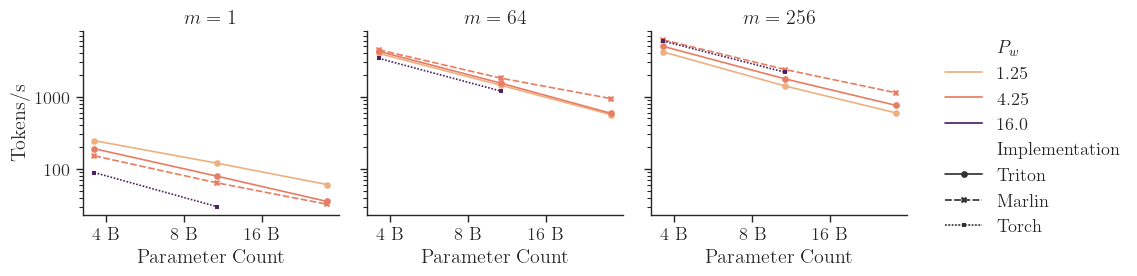

In [7]:
d = (df
    .pipe(lambda d: d[~d.impl.isin(["torch.compile", "Marlin (Linear)"])])
    .pipe(lambda d: d[d.batch_size.isin([1, 64, 256])])
)
print("Relative 2*stderr mean", 2 * (d.tokens_s_stderr / d.tokens_s).mean())
print("Relative 2*stderr max", 2 * (d.tokens_s_stderr / d.tokens_s).max())

g = sns.relplot(data=d, y="tokens_s", x="parameters", col="batch_size", hue="avg_bits",
                style="impl", style_order=["Triton", "Marlin", "Torch"],
                kind="line", palette=plot_utils.SEQ_PALETTE,
                height=3, aspect=0.9, mew=0, markers=True)
for m, ax in g.axes_dict.items():
    ax.set_xscale("log", base=2)
    ax.xaxis.set_major_formatter(lambda x, _: f"{x/2**30:.0f} B")
    ax.set_yscale("log")
    ax.yaxis.set_major_formatter("{x:.0f}")
    ax.set_title(f"$m={m}$")
g.figure.legend(
    handles=g.legend.legend_handles,
    labels=[text.get_text() for text in g.legend.get_texts()],
    loc="center left",
    bbox_to_anchor=(1, 0.5),
)
plot_utils.tidy(g.figure)
# plot_utils.save("perf_model_params_m_bits_impl")

Relative 2*stderr mean 0.0003937507972367792
Relative 2*stderr max 0.00169051247200207


remote: Updating references: 100% (1/1)           


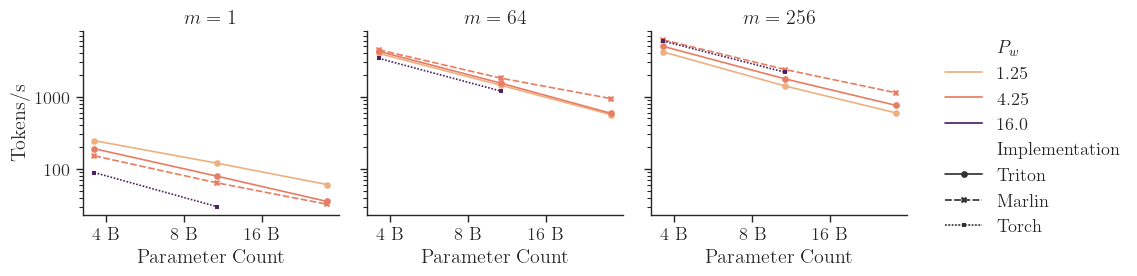

In [11]:
d = (df
    .pipe(lambda d: d[~d.impl.isin(["torch.compile", "Marlin (Linear)"])])
    .pipe(lambda d: d[d.batch_size.isin([1, 64, 256])])
)
print("Relative 2*stderr mean", 2 * (d.tokens_s_stderr / d.tokens_s).mean())
print("Relative 2*stderr max", 2 * (d.tokens_s_stderr / d.tokens_s).max())

g = sns.relplot(data=d, y="tokens_s", x="parameters", col="batch_size", hue="avg_bits",
                style="impl", style_order=["Triton", "Marlin", "Torch"],
                kind="line", palette=plot_utils.SEQ_PALETTE,
                height=3, aspect=0.9, mew=0, markers=True)
for m, ax in g.axes_dict.items():
    ax.set_xscale("log", base=2)
    ax.xaxis.set_major_formatter(lambda x, _: f"{x/2**30:.0f} B")
    ax.set_yscale("log")
    ax.yaxis.set_major_formatter("{x:.0f}")
    ax.set_title(f"$m={m}$")
g.figure.legend(
    handles=g.legend.legend_handles,
    labels=[text.get_text() for text in g.legend.get_texts()],
    loc="center left",
    bbox_to_anchor=(1, 0.5),
)
plot_utils.tidy(g.figure)
plot_utils.save("perf_model_params_m_bits_impl")

## `tables/perf_model_m1_impl`

In [10]:
def token_s_highlighted(s: pd.Series) -> str:
    text = f"${s.tokens_s:.1f}$"
    if (s.impl, s.element_bits, s.model) in {("Torch", 16, "4B"), ("Triton", 4, "12B"), ("Triton", 1, "31B")}:
        text = f"\\color{{blue}}{{{text}}}"
    return text

d = (df
    .pipe(lambda d: d[d.batch_size==1])
    .pipe(lambda d: d[d.impl!="torch.compile"])
    .pipe(lambda d: d.assign(tokens_s_str=d.apply(token_s_highlighted, axis=1)))
)
t = (d
    .pivot(index=["avg_bits", "impl"], columns="model", values="tokens_s_str")[["4B", "12B", "31B"]].reset_index()
    .pipe(lambda d: d.assign(rank=d.apply(lambda s: (-s.avg_bits, ["Torch", "Triton", "Marlin", "Marlin (Linear)"].index(s.impl)), axis=1)))
    .sort_values("rank").drop(columns=["rank"])
)

print("Relative 2*stderr mean", 2 * (d.tokens_s_stderr / d.tokens_s).mean())
print("Relative 2*stderr max", 2 * (d.tokens_s_stderr / d.tokens_s).max())

display(d.pivot(index=["avg_bits", "impl"], columns="model", values="tokens_s")[["4B", "12B", "31B"]])
display(d.pivot(index=["avg_bits", "impl"], columns="model", values="gb_s")[["4B", "12B", "31B"]].style.format("{:.0f} GB/s"))

args = dict(cols={k: "" for k in ["avg_bits", "impl", "4B", "12B", "31B"]},
            align="llrrr", nan_str="OOM")
print(plot_utils.fmt_latex_booktabs(t, **args))
plot_utils.save_table("perf_model_m1_impl", t, **args)

Relative 2*stderr mean 0.00011349147933765257
Relative 2*stderr max 0.0003671654151743351


model                             4B         12B        31B
avg_bits impl                                              
1.25     Triton           245.586348  119.964358  60.722270
4.25     Marlin           151.521331   64.099803  32.360355
         Marlin (Linear)  156.151749   65.471591  32.826245
         Triton           190.100723   79.284413  35.389009
16.00    Torch             88.837412   30.002909        NaN

\begin{tabular}{llrrr} \toprule
  $P_w$ & Implementation & 4B & 12B & 31B \\\midrule
  $16$ & Torch & \color{blue}{$88.8$} & $30.0$ & OOM \\
  $4.25$ & Triton & $190.1$ & \color{blue}{$79.3$} & $35.4$ \\
  $4.25$ & Marlin & $151.5$ & $64.1$ & $32.4$ \\
  $4.25$ & Marlin (Linear) & $156.2$ & $65.5$ & $32.8$ \\
  $1.25$ & Triton & $245.6$ & $120.0$ & \color{blue}{$60.7$} \\
\bottomrule
\end{tabular}


remote: Updating references: 100% (1/1)           
